In [185]:
import random
import time

# Imports

import pickle

import pandas as pd
import numpy as np
import random
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sns.set()

In [3]:
# Importing gym and its other stuff
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) # err only

env = gym.make("CartPole-v1")

In [95]:
### LOGGING OBJECT

class Logger:
    def __init__(self, filename='./data.csv'):
        self.filename = filename

    def __parseStats(self, stats) -> str:
        print(stats)
        obsv = stats[0]
        reward = stats[1]
        done = stats[2]
        info = stats[3]

        obsvCSV = ','.join([x.astype(str) for x in obsv])
        return f"{obsvCSV},{reward},{done},{info}"

    def log(self, stats, action, totalReward) -> None:
        # open file
        self.__parseStats(stats=stats)
        with open(self.filename, 'a') as file:
            file.write(f"{self.__parseStats(stats=stats)},{totalReward},{action}\n")
            pass


In [140]:
### Agent OBJECT

class Agent:
    def __init__(self, environment, logger:Logger) -> None:
        self.env = environment
        self.logger = logger
        self.isRunning = True
        self.curReward = 0

    def __reset(self):
        startState = self.env.reset()
        self.isRunning = True
        self.curReward = 0
        return startState

    def policy(self) -> int:
        return random.randint(0,1)

    def run(self) -> None:
        self.__reset()
        while self.isRunning:
            action = self.policy() # determining action
            stats = self.env.step(action) # execute action

            # update state
            self.isRunning = stats[2]==False
            self.curReward += stats[1] if self.isRunning else 0

            # log information etc
            self.logger.log(stats=stats, action=action, totalReward=self.curReward)

In [142]:
for _ in range(1000):
    agt = Agent(gym.make("CartPole-v1"), Logger())
    agt.run()

(array([ 0.00895683,  0.23537427,  0.01402994, -0.32992718], dtype=float32), 1.0, False, False, {})
(array([ 0.00895683,  0.23537427,  0.01402994, -0.32992718], dtype=float32), 1.0, False, False, {})
(array([ 0.01366432,  0.43029374,  0.00743139, -0.6181529 ], dtype=float32), 1.0, False, False, {})
(array([ 0.01366432,  0.43029374,  0.00743139, -0.6181529 ], dtype=float32), 1.0, False, False, {})
(array([ 0.02227019,  0.23506877, -0.00493167, -0.32313874], dtype=float32), 1.0, False, False, {})
(array([ 0.02227019,  0.23506877, -0.00493167, -0.32313874], dtype=float32), 1.0, False, False, {})
(array([ 0.02697157,  0.04001739, -0.01139444, -0.03201512], dtype=float32), 1.0, False, False, {})
(array([ 0.02697157,  0.04001739, -0.01139444, -0.03201512], dtype=float32), 1.0, False, False, {})
(array([ 0.02777191, -0.15493932, -0.01203474,  0.25705108], dtype=float32), 1.0, False, False, {})
(array([ 0.02777191, -0.15493932, -0.01203474,  0.25705108], dtype=float32), 1.0, False, False, {})


# Analysing data

Q-learning requires discrete states from the environment, however, the Cartpole problem provides states that are continuous.


We can approach this by creating discrete steps in the environment. While this can be done through trial & error by making intuitive guesses on the different states, a more calculative approach will be to use machine learning to create clusters ("buckets") to be used as our steps.

In [143]:
### Importing data

rawData = pd.read_csv('./data.csv')
rawData

cartPos   cartVel   poleAngle   poleVel   reward   done  \
0      0.024236  0.191275    0.003320 -0.287982      1.0  False   
1      0.028062 -0.003895   -0.002439  0.005746      1.0  False   
2      0.027984  0.191262   -0.002324 -0.287706      1.0  False   
3      0.031809 -0.003826   -0.008079  0.004243      1.0  False   
4      0.031733  0.191410   -0.007994 -0.290978      1.0  False   
...         ...       ...         ...       ...      ...    ...   
29467 -0.079023 -0.392087    0.158651  0.798232      1.0  False   
29468 -0.086865 -0.199456    0.174616  0.559363      1.0  False   
29469 -0.090854 -0.396543    0.185803  0.901575      1.0  False   
29470 -0.098785 -0.204358    0.203835  0.672572      1.0  False   
29471 -0.102872 -0.401642    0.217286  1.021885      1.0   True   

       idkwhatthisis  totalReward  action  
0              False          1.0       1  
1              False          2.0       0  
2              False          3.0       1  
3              False          4.0       0  
4              False          5.0       1  
...              ...          ...     ...  
29467          False         22.0       0  
29468          False         23.0       1  
29469          False         24.0       0  
29470          False         25.0       1  
29471          False         25.0       0  

[29472 rows x 9 columns]

## Clustering Approach

There are a handful of methods we can use to cluster our data for prediction.
* Affinity propagation
* Mean-shift
* K-means (not optimal as we have to determine the number of 'buckets')

In [144]:
obsvData = rawData[['cartPos', 'cartVel', ' poleAngle', ' poleVel']]
obsvData

cartPos   cartVel   poleAngle   poleVel
0      0.024236  0.191275    0.003320 -0.287982
1      0.028062 -0.003895   -0.002439  0.005746
2      0.027984  0.191262   -0.002324 -0.287706
3      0.031809 -0.003826   -0.008079  0.004243
4      0.031733  0.191410   -0.007994 -0.290978
...         ...       ...         ...       ...
29467 -0.079023 -0.392087    0.158651  0.798232
29468 -0.086865 -0.199456    0.174616  0.559363
29469 -0.090854 -0.396543    0.185803  0.901575
29470 -0.098785 -0.204358    0.203835  0.672572
29471 -0.102872 -0.401642    0.217286  1.021885

[29472 rows x 4 columns]

### EDA

We first begin by doing surface level data analysis.

As we observe the plot below, we can observe that certain attributes have much stronger relations than others.

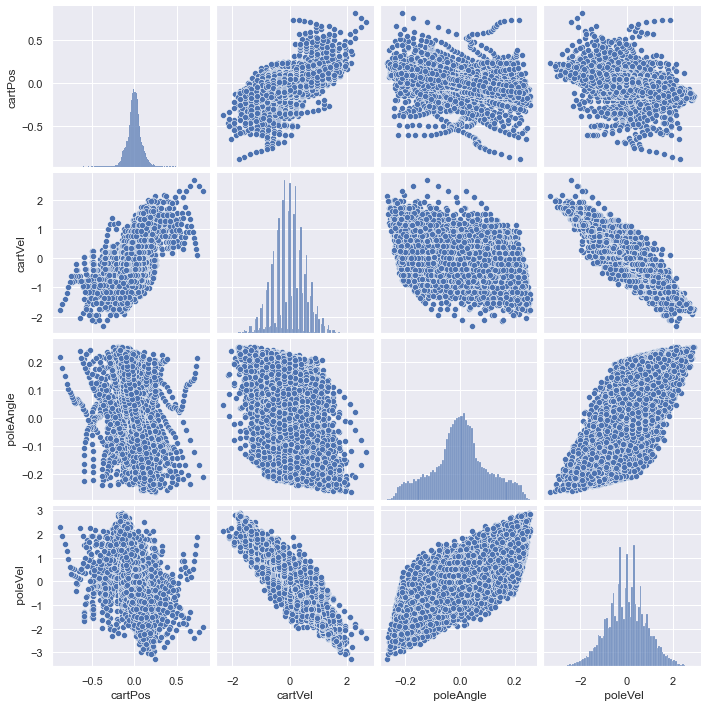

In [145]:
sns.pairplot(obsvData)

### Splitting data into test and training data

In [146]:
dataTrain, dataTest = train_test_split(obsvData, test_size=0.4)

dataTrain

cartPos   cartVel   poleAngle   poleVel
11532  0.032842  0.540158   -0.053929 -0.880915
12701  0.068761  0.970871   -0.013482 -1.376618
5492  -0.064899 -0.048634    0.050996  0.073136
600   -0.040542 -0.394466    0.106380  0.770726
5117  -0.036715  0.337636    0.166984  0.147215
...         ...       ...         ...       ...
26311 -0.083934 -0.013280    0.052826 -0.023887
8962   0.045783  0.595210   -0.038312 -0.911090
19782  0.008538  0.205247    0.064761 -0.201731
2345  -0.084406  0.200766    0.179798  0.201231
14118  0.063869  1.107306    0.017102 -0.980705

[17683 rows x 4 columns]

{2: 7383.340689044634, 3: 4139.897791929245, 4: 2747.520040300231, 5: 2084.5037561860445, 6: 1662.2794560297589, 7: 1412.8124352390432, 8: 1252.443699951243, 9: 1114.1044114635645, 10: 1022.944301811969, 11: 935.8577262728874, 12: 883.0841816733887, 13: 835.4674350425223, 14: 786.9674435657556, 15: 741.8900705557223}


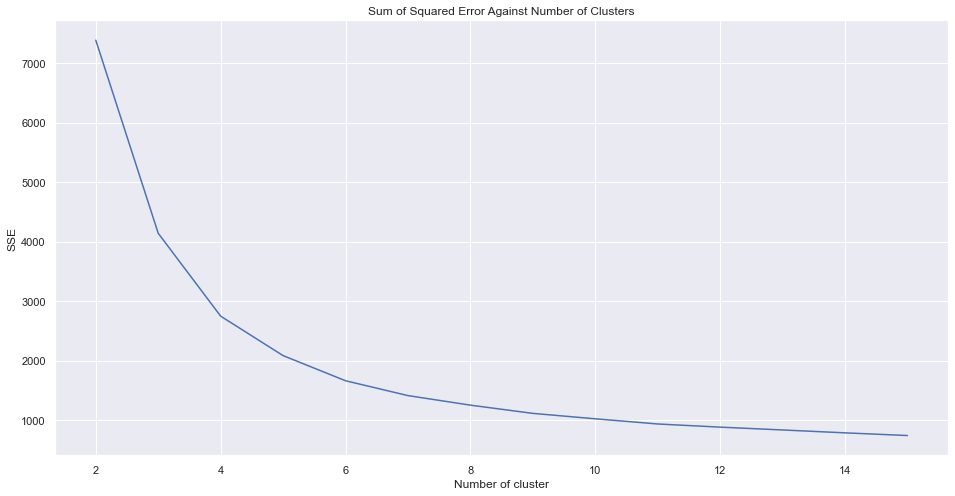

In [188]:
def testKMean():
    sse = {}
    for i in range(2, 16):
        model = cluster.KMeans(init="k-means++",n_clusters=i).fit(dataTrain)
        sse[i] = model.inertia_

        # exporting models
        with open(f"./models/klearn_{i}.pkl", "wb") as modelFile:
            pickle.dump(model, modelFile)

    print(sse)
    plt.figure(figsize=(16,8))
    plt.title("Sum of Squared Error Against Number of Clusters")
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")





testKMean()

In [190]:
### testing importing model
modelLoad = open('./models/klearn_8.pkl', 'rb')
thisModel = pickle.load(modelLoad)
modelLoad.close()

thisModel.score(dataTest)

-825.2431939887601